# **Implementation from scratch of a Vision Transformer**

# **I) Model**

In [86]:
import torch
from torch import nn

In [87]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## **1) Patch**

In [88]:
class Patcher(nn.Module):
    def __init__(self, patch_length):
        super().__init__()
        self.patch_length = patch_length

    def forward(self, x):
        """ 
        il faut revoir la manière dont on fait le patch, ça ne le fait pas de la bonne manière
        """
        batch_size, h, w = x.shape
        nb_patchs = h*w // (self.patch_length**2)

        res = torch.ones(batch_size, nb_patchs, self.patch_length**2)

        for batch in range(batch_size):
          for i in range(0, h, self.patch_length):
            for j in range(0, w, self.patch_length):
              patch_index = ( (h // self.patch_length) * i + j ) // self.patch_length
              res[batch, patch_index] = torch.flatten(x[batch, i:i+self.patch_length, j:j+self.patch_length])

        cls = torch.ones(batch_size, 1, self.patch_length**2)
        res = torch.cat((cls, res), 1)

        return res

patcher = Patcher(patch_length=2)
x = torch.rand(32, 28, 28)
res = patcher(x)
print(res.shape)
assert torch.equal(res[0, 1], torch.flatten(x[0, 0:2, 0:2]))

torch.Size([32, 197, 4])


## **2) Encoder**

For the Encoder part, I re-used a code I had already written to implement a transformer from scratch (at https://github.com/yanisadel/ML-from-scratch, file Transformer.ipynb)

In [89]:
def get_positional_embedding(batch_size, nb_tokens, embedding_dim):
  """
  Takes as input the shape (batch_size, nb_tokens, embedding_dim),
  and returns a positional encoding tensor with shape (batch_size, nb_tokens, embedding_dim)
  """
  embedding = torch.rand(nb_tokens, embedding_dim)
  for pos in range(nb_tokens):
    for i in range(0, embedding_dim, 2):
      embedding[pos][i] = torch.sin(torch.Tensor([pos / 10000**(2*i/embedding_dim)]))
    for i in range(1, embedding_dim, 2):
      embedding[pos][i] = torch.cos(torch.Tensor([pos / 10000**(2*i/embedding_dim)]))

  return embedding.repeat(batch_size, 1, 1)

class ScaledDotProductAttention(nn.Module):
  """
  Takes as input a query, a key and a value,
  that have shape (batch_size, nb_tokens, embedding_dim),
  performs Scaled-Dot-Product Attention 
  and returns a (batch_size, nb_tokens, embedding_dim) tensor
  """
  def __init__(self, embedding_dim, **kwargs):
    super(**kwargs).__init__()
    self.query_layer = nn.Linear(embedding_dim, embedding_dim)
    self.key_layer = nn.Linear(embedding_dim, embedding_dim)
    self.value_layer = nn.Linear(embedding_dim, embedding_dim)

  def forward(self, query, key, value, mask=None, training=False):
    batch_size, nb_tokens, embedding_dim = query.shape
    Q = self.query_layer(query)
    K = self.key_layer(key)
    V = self.value_layer(value)
    K_transpose = torch.transpose(K, 1, 2)
    QK = torch.matmul(Q, K_transpose)
    
    QK_normalized = QK / (embedding_dim**(1/2))

    if mask != None:
      QK_shape = QK_normalized.shape
      if len(mask.shape) == len(QK_shape) - 1:
        mask = mask.unsqueeze(1).repeat(1, mask.shape[-1], 1)
      
      if mask.shape != QK_shape:
        raise Exception("The shape of the mask is not correct (the shape is {} instead of {} or {})".format(mask.shape, QK_shape[:-1], QK_shape))

      QK_normalized *= mask
              
    softmax = nn.Softmax(dim=2)(QK_normalized)
    res = torch.matmul(softmax, V)

    return res

class MultiHeadAttentionLayer(nn.Module):
  """
  Takes as input a query, a key and a value,
  that have shape (batch_size, nb_tokens, embedding_dim),
  performs a Multi-head Attention over the token embeddings 
  and returns a (batch_size, nb_tokens, embedding_dim) tensor
  """
  def __init__(self, attention_heads, embedding_dim, **kwargs):
    super(**kwargs).__init__()
    self.attention_heads = attention_heads
    self.embedding_dim = embedding_dim
    self.attention_layers = [ScaledDotProductAttention(embedding_dim=embedding_dim//attention_heads) for _ in range(attention_heads)]

  def forward(self, query, key, value, mask=None, training=False):
    batch_size, nb_tokens, embedding_dim = query.shape
    query = query.reshape(batch_size, nb_tokens, self.attention_heads, embedding_dim // self.attention_heads)
    key = key.reshape(batch_size, nb_tokens, self.attention_heads, embedding_dim // self.attention_heads)
    value = value.reshape(batch_size, nb_tokens, self.attention_heads, embedding_dim // self.attention_heads)
    
    concat = torch.Tensor()
    for i, attention_layer in enumerate(self.attention_layers):
      attention = attention_layer(query[:, :, i, :], key[:, :, i, :], value[:, :, i, :], mask=mask, training=training)
      concat = torch.concat([concat, attention], dim=2)
  
    return concat

class FeedforwardLayer(nn.Module):
  """
  Takes as input a tensor x (batch_size, nb_tokens, embedding_dim),
  and passes it through a dense, a relu, a dense, and a dropout layer
  It returns a tensor (batch_size, nb_tokens, embedding_dim)
  """
  def __init__(self, embedding_dim, dropout_rate, **kwargs):
    super(**kwargs).__init__()
    self.dense1 = nn.Linear(embedding_dim, embedding_dim)
    self.dense2 = nn.Linear(embedding_dim, embedding_dim)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(dropout_rate)

  def forward(self, x, training=False):
    x = self.dense1(x)
    x = self.relu(x)
    x = self.dense2(x)
    if training:
      x = self.dropout(x)
    return x

class EncoderLayer(nn.Module):
  """
  EncoderLayer that takes as input a tensor (batch_size, nb_tokens, embedding_dim)
  and returns a tensor (batch_size, nb_tokens, embedding_dim)
  It represents one stack of the Encoder, so it performs multi head attention,
  then layer normalization, and then feedforward network
  """
  def __init__(self, embedding_dim, attention_heads, dropout_rate, **kwargs):
    super(**kwargs).__init__()
    self.multi_head_attention = MultiHeadAttentionLayer(attention_heads=8, embedding_dim=embedding_dim)
    self.feedforward = FeedforwardLayer(embedding_dim=embedding_dim, dropout_rate=dropout_rate)
    self.layer_norm = nn.LayerNorm(embedding_dim)
    self.dropout = nn.Dropout(dropout_rate)
    self.relu = nn.ReLU()

  def forward(self, x, mask=None, training=False):
    mha_output = self.multi_head_attention(x, x, x, mask=mask, training=training)
    if training:
      multi_head_attention_output = self.dropout(mha_output)
    x = self.layer_norm(x + mha_output)
    x = self.layer_norm(x + self.feedforward(x, training=training))

    return x

class Encoder(nn.Module):
  """
  Encoder of the transformer that takes as input a tensor (batch_size, nb_tokens)
  and returns a tensor (batch_size, nb_tokens, embedding_dim)
  """
  def __init__(self, nb_layers, patch_length, embedding_dim, attention_heads, dropout_rate, **kwargs):
    super(**kwargs).__init__()
    self.embedding_layer = nn.Linear(patch_length**2, embedding_dim)
    self.encoder_layers = nn.ModuleList([EncoderLayer(embedding_dim=embedding_dim, attention_heads=attention_heads, dropout_rate=dropout_rate) for _ in range(nb_layers)])

  def forward(self, x, mask=None, training=False):
    x = self.embedding_layer(x)
    x += get_positional_embedding(x.shape[0], x.shape[1], x.shape[2])
    for encoder_layer in self.encoder_layers:
      x = encoder_layer(x, mask=mask, training=training)

    return x

model = Encoder(nb_layers=6, patch_length=4, embedding_dim=512, attention_heads=8, dropout_rate=0.1)
x = torch.rand(32, 50, 16)
res = model(x)
res.shape

torch.Size([32, 50, 512])

## **3) Vision Transformer**

In [90]:
class ViT(nn.Module):
  """
  Takes as input a batch of images (batch_size, height, width) (with height=width)
  and returns a tensor (batch_size, height*width / (patch_length**2), embedding_dim)

  It separates the image into patches, flattens the patches, then it goes through a transformer,
  and through a MLP layer with a softmax layer to get class probabilities
  """

  def __init__(self, num_classes, nb_layers, patch_length, embedding_dim, attention_heads, dropout_rate):
    """
      num_classes (int): number of classes we want to predict
      nb_layers (int): number of layers of the encoder
      patch_length (int): length of the patchs on the image
      embedding_dim (int): embedding dimension for the vectors inside the transformer
      attention_heads (int): number of attention heads inside the transformer
      dropout_rate (int): dropout rate for the MLP layers inside the transformer
    """
    super().__init__()
    self.patcher = Patcher(patch_length)
    self.encoder = Encoder(nb_layers, patch_length, embedding_dim, attention_heads, dropout_rate)
    self.linear = nn.Linear(embedding_dim, num_classes)
    self.softmax = nn.Softmax(dim=1)

  def forward(self, x, training=False):
    x = self.patcher(x)
    x = self.encoder(x, training=training)
    x = x[:, 0] # get cls_token
    x = self.linear(x)
    x = self.softmax(x)

    return x


x = torch.rand(32, 28, 28)
model = ViT(num_classes=10, nb_layers=6, patch_length=4, embedding_dim=512, attention_heads=8, dropout_rate=0.1)
assert model(x, training=True).shape == (32, 10)
model

ViT(
  (patcher): Patcher()
  (encoder): Encoder(
    (embedding_layer): Linear(in_features=16, out_features=512, bias=True)
    (encoder_layers): ModuleList(
      (0): EncoderLayer(
        (multi_head_attention): MultiHeadAttentionLayer()
        (feedforward): FeedforwardLayer(
          (dense1): Linear(in_features=512, out_features=512, bias=True)
          (dense2): Linear(in_features=512, out_features=512, bias=True)
          (relu): ReLU()
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (relu): ReLU()
      )
      (1): EncoderLayer(
        (multi_head_attention): MultiHeadAttentionLayer()
        (feedforward): FeedforwardLayer(
          (dense1): Linear(in_features=512, out_features=512, bias=True)
          (dense2): Linear(in_features=512, out_features=512, bias=True)
          (relu): ReLU()
          (dropout): Dropout(p=0.1

# **II) Test**

## **1) Récupération des données**

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
!cp drive/MyDrive/IA/kaggle.json /root/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c digit-recognizer

In [ ]:
!unzip digit-recognizer.zip

## **2) Chargement des données et visualisation**

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [92]:
df = pd.read_csv("train.csv")
print(df.shape)
df.head(1)

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [93]:
y = df['label'].to_numpy()
X = df.drop(columns=['label']).to_numpy().reshape(-1, 28, 28)

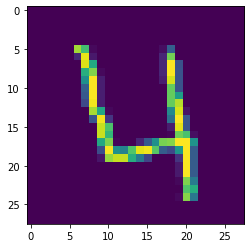

In [94]:
plt.imshow(X[3])
plt.show()

## **3) Dataloader**

In [96]:
from torch.utils.data import DataLoader, Dataset

class Data(Dataset):
    """
    Dataset qui contient deux listes de strings (text1 et text2) ainsi qu'une liste de similarités entre ces strings (target)
    """
    def __init__(self, images, labels):      
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]

        return image, label
  

dataset = Data(X[:2000], y[:2000])
test_size = 0.2
nb_rows = len(dataset)
nb_rows_train = int((1 - test_size) * nb_rows)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [nb_rows_train, nb_rows - nb_rows_train])

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

## **4) Define model and optimizer**

In [100]:
patch_length = 4
nb_layers = 4
embedding_dim = 512
attention_heads = 8
dropout_rate = 0.1
num_classes = 10

learning_rate = 1e-3
print("Number of patchs on an image : ", 28**2 / (patch_length**2))

Number of patchs on an image :  49.0


In [101]:
model = ViT(num_classes=num_classes, 
            nb_layers=nb_layers, 
            patch_length=patch_length, 
            embedding_dim=embedding_dim, 
            attention_heads=attention_heads, 
            dropout_rate=dropout_rate)
loss_object = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## **5) Train**

In [102]:
from tqdm import tqdm

EPOCHS = 5

losses_train = []
losses_test = []

for epoch in range(EPOCHS):
    running_loss_train = 0
    running_loss_test = 0
    print("Epoch {}/{}".format(epoch+1, EPOCHS))
    for images, labels in tqdm(train_dataloader):
        optimizer.zero_grad() 
        outputs = model(images, training=True)
        loss = loss_object(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss_train += loss.item()

    running_loss_train /= len(train_dataloader)
    losses_train.append(running_loss_train)

    with torch.no_grad():
        for images, labels in test_dataloader:
          outputs = model(images)
          loss = loss_object(outputs, labels)
          running_loss_test += loss.item()

    running_loss_test /= len(test_dataloader)
    losses_test.append(running_loss_test)

    print("Train Loss : {}, Test Loss : {}".format(running_loss_train, running_loss_test))

Epoch 1/5


100%|██████████| 50/50 [01:17<00:00,  1.55s/it]


Train Loss : 2.285724139213562, Test Loss : 2.2894969903505764
Epoch 2/5


100%|██████████| 50/50 [01:22<00:00,  1.64s/it]


Train Loss : 2.253756012916565, Test Loss : 2.279659179540781
Epoch 3/5


100%|██████████| 50/50 [01:20<00:00,  1.60s/it]


Train Loss : 2.227060856819153, Test Loss : 2.234089759679941
Epoch 4/5


100%|██████████| 50/50 [01:20<00:00,  1.61s/it]


Train Loss : 2.285259804725647, Test Loss : 2.374514543093168
Epoch 5/5


100%|██████████| 50/50 [01:18<00:00,  1.56s/it]


Train Loss : 2.319807324409485, Test Loss : 2.3216814261216383
